# Assignment 4

## Part 1

### Imports

In [41]:
# Import libraries
!pip -q install seaborn geopandas matplotlib IP2Location folium
import folium
import os
import json
import IP2Location
import pytz
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from folium.plugins import HeatMap
from urllib.request import urlopen
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data

In [42]:
# Streaming data from 2016-2025
stream_folder = '/content/drive/MyDrive/Datasets/Spotify/Streaming/'
stream_data = [
    {
        'ts': entry.get('ts'), # UTC format
        'platform': entry.get('platform'),
        'ms_played': entry.get('ms_played'),
        'ip': entry.get('ip_addr'),
        'reason_start': entry.get('reason_start'),
        'reason_end': entry.get('reason_end'),
        'incognito_mode': entry.get('incognito_mode'),
        'skipped': entry.get('skipped'),
        'offline': entry.get('offline')
    }
    for f in os.listdir(stream_folder) if f.endswith('.json')
    for entry in json.load(open(os.path.join(stream_folder, f), 'r'))
]

# Inferences and profile data
profile_folder = '/content/drive/MyDrive/Datasets/Spotify/Profile/'
inferences = json.load(open(os.path.join(profile_folder, 'Inferences.json')))
identity = json.load(open(os.path.join(profile_folder, 'Identity.json')))
identifiers = json.load(open(os.path.join(profile_folder, 'Identifiers.json')))
profile = json.load(open(os.path.join(profile_folder, 'Userdata.json')))

### Descriptives

In [ ]:
# Gender, age, name, email, address, country, role (student)
profile['email'] = 'dhan1238@umd.edu'
profile['postalCode'] = '08901'
profile['mobileNumber'] = '123-456-7890'
print(profile)

# Devices/platforms you have used, ISP and mobile carriers
print(inferences)

{'username': '•••davidhan•••', 'email': 'dhan1238@umd.edu', 'country': 'US', 'createdFromFacebook': False, 'facebookUid': None, 'birthdate': '1999-08-29', 'gender': 'male', 'postalCode': '08901', 'mobileNumber': '123-456-7890', 'mobileOperator': None, 'mobileBrand': None, 'creationTime': '2016-12-21', 'assuredEstimatedAge': None, 'assuredAgeMethod': None, 'assuredAgeTimestamp': None}
{'inferences': ['1P_Custom_Affinity_Remitly [Advertiser-Specific]', '1P_Custom_Apple_Airpods_Streamers [Advertiser-Restricted]', '1P_Custom_Canadian_Artist_Listeners', '1P_Custom_Enthusiatic_Mood_Listeners', '1P_Custom_Heartbreak_Playlist_Listeners', '1P_Custom_Moody_Listeners', '1P_Custom_Students', '1P_Custom_T-Mobile_Switchers [Advertiser-Restricted]', '1P_Custom_Verizon_Carrier_Only [Advertiser-Specific]', '1P_Custom_Verizon_Fios_ISP [Advertiser-Specific]', '1P_Custom_Verizon_Users_All', '1P_Custom_iOS_Mobile_Streamers [Advertiser-Restricted]', 'Test_Has_IDFA']}


### Engagement

In [ ]:
# Total screentime
# I haven't received my technical log data yet, so I don't think I can do this
# metric for now :(

# Number of UI interactions (app open, close, song skip, etc.)
skips = 0
replays = 0
for entry in stream_data:
  start = entry.get('reason_start')
  end = entry.get('reason_end')
  if entry.get('skipped') or start == 'fwdbtn' or end == 'fwdbtn':
    skips += 1
  elif start == 'backbtn' or end == 'backbtn':
    replays += 1
print(f'Total skips: {skips}\nTotal replays: {replays}')

# Time listened offline vs online
online_streams = 0
offline_streams = 0
for entry in stream_data:
  ms = entry.get('ms_played')
  if ms >= 30000:
    if entry.get('offline'):
      offline_streams += ms
    else:
      online_streams += ms
print(f'Online streaming time: {online_streams/3600000:.2f} hours')
print(f'Offline streaming time: {offline_streams/3600000:.2f} hours')

# Time listened in private sessions
private_streams = 0
public_streams = 0
for entry in stream_data:
  ms = entry.get('ms_played')
  if ms >= 30000:
    if entry.get('incognito_mode'):
      private_streams += ms
    else:
      public_streams += ms
print(f'Public streaming time: {public_streams/3600000:.2f} hours')
print(f'Private streaming time: {private_streams/3600000:.2f} hours')

Total skips: 241606
Total replays: 6786
Online streaming time: 8390.12 hours
Offline streaming time: 55.06 hours
Public streaming time: 8340.90 hours
Private streaming time: 104.28 hours


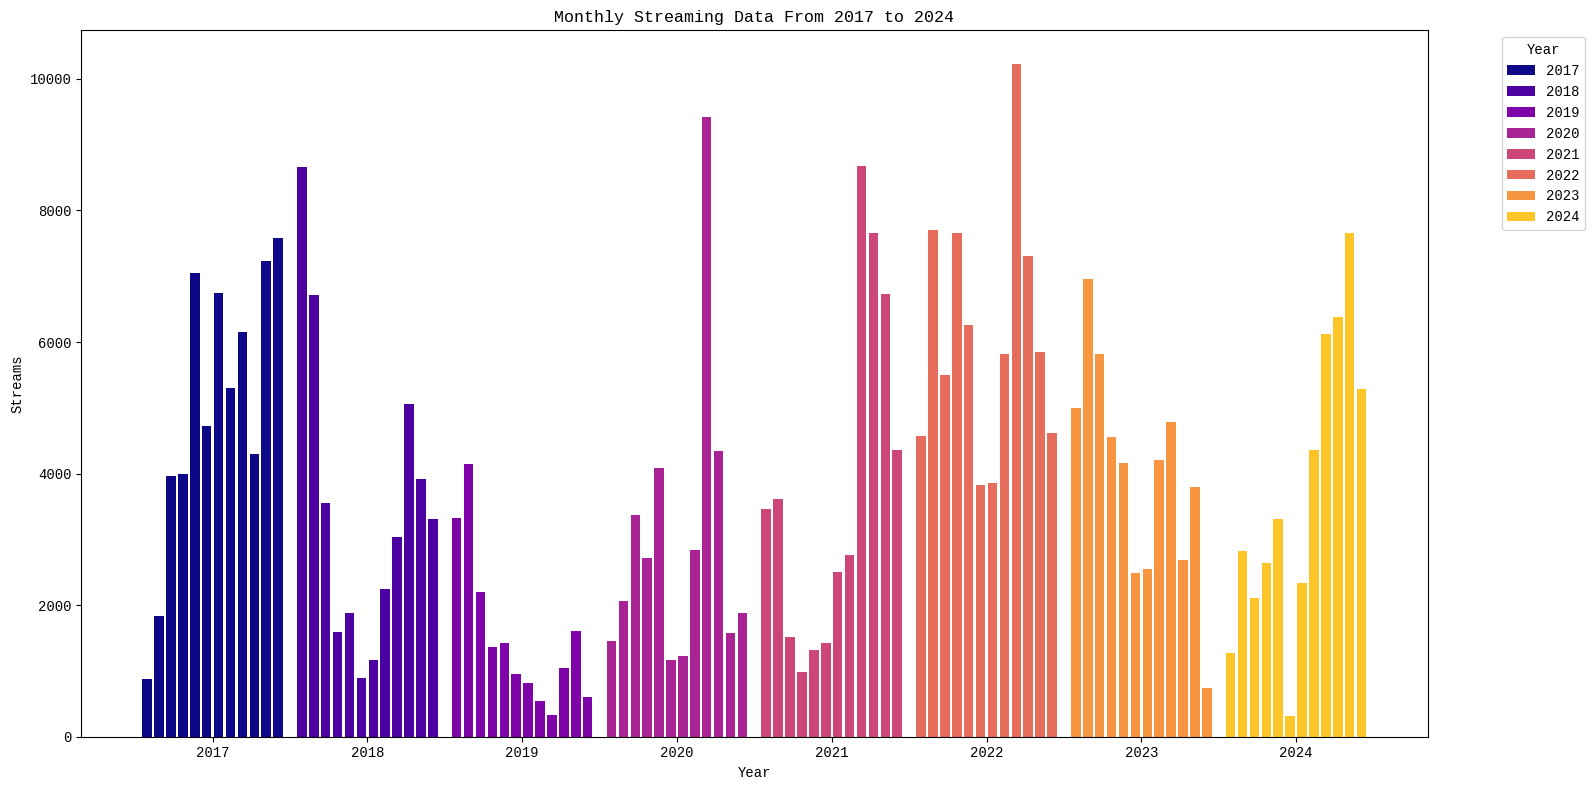

In [70]:
# Convert the timestamps to datetime and convert to a dataframe
for entry in stream_data:
    entry['ts'] = pd.to_datetime(entry['ts'], utc=True)
df = pd.DataFrame(stream_data)

# Extract year and month from the timestamp ts
df['year'] = df['ts'].dt.year
df['month'] = df['ts'].dt.month

# Group by year and month and count streams
monthly_activity = df.groupby(['year', 'month']).size().reset_index(name='stream_count')
hm_data = monthly_activity.pivot(index='year', columns='month', values='stream_count')
hm_data = hm_data.drop([2016, 2025], axis=0)

plt.figure(figsize=(16, 8))

# Plot each year's data sequentially on the x axis
bar_colors = matplotlib.colormaps['plasma']
for i, year in enumerate(hm_data.index):
    year_data = hm_data.loc[year]
    x_pos = np.arange(12) + i * 13
    plt.bar(x_pos, year_data, width=0.8, label=str(year), color=bar_colors(i / len(hm_data.index)))

# Set the x-axis labels (positions)
plt.xticks(np.arange(len(hm_data.index)) * 13 + 5.5, hm_data.index)
plt.xlabel('Year')
plt.ylabel('Streams')
plt.title('Monthly Streaming Data From 2017 to 2024')
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

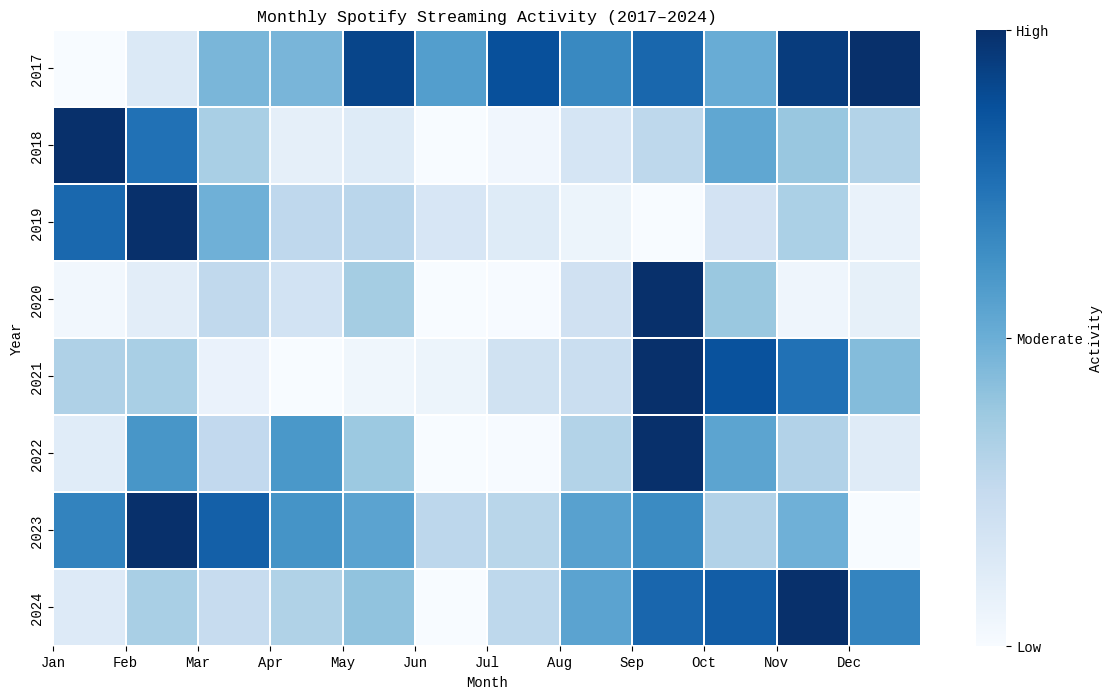

In [44]:
# Convert the timestamps to datetime and convert to a dataframe
for entry in stream_data:
    entry['ts'] = pd.to_datetime(entry['ts'], utc=True)
df = pd.DataFrame(stream_data)

# Extract year and month from the timestamp ts
df['year'] = df['ts'].dt.year
df['month'] = df['ts'].dt.month

# Group by year and month and count streams
monthly_activity = df.groupby(['year', 'month']).size().reset_index(name='stream_count')
hm_data = monthly_activity.pivot(index='year', columns='month', values='stream_count')
hm_data = hm_data.drop([2016, 2025], axis=0)

# Set up the plot
plt.figure(figsize=(14, 8))

# Normalize the color scale for each year independently
for year in hm_data.index:
    year_data = hm_data.loc[year, :]
    norm = (year_data - year_data.min()) / (year_data.max() - year_data.min())
    hm_data.loc[year, :] = norm

# Create the heatmap
ax = sns.heatmap(hm_data, cmap='Blues', annot=False, linewidths=0.1, cbar_kws={'label': 'Activity'})
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['Low', 'Moderate', 'High'])

# Show the heatmap
plt.rcParams['font.family'] = 'Liberation Mono'
plt.xlabel('Month')
plt.ylabel('Year')
plt.title('Monthly Spotify Streaming Activity (2017–2024)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

<ipython-input-9-5271d00b3d1f>:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3765470946087686' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hm_data.loc[year, :] = norm
<ipython-input-9-5271d00b3d1f>:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07614852108244179' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hm_data.loc[year, :] = norm
<ipython-input-9-5271d00b3d1f>:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4797566603734005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hm_data.loc[year, :] = norm
<ipython-input-9-5271d00b3d1f>:22: FutureWarning: Setting an item of incompatible dtype is depre

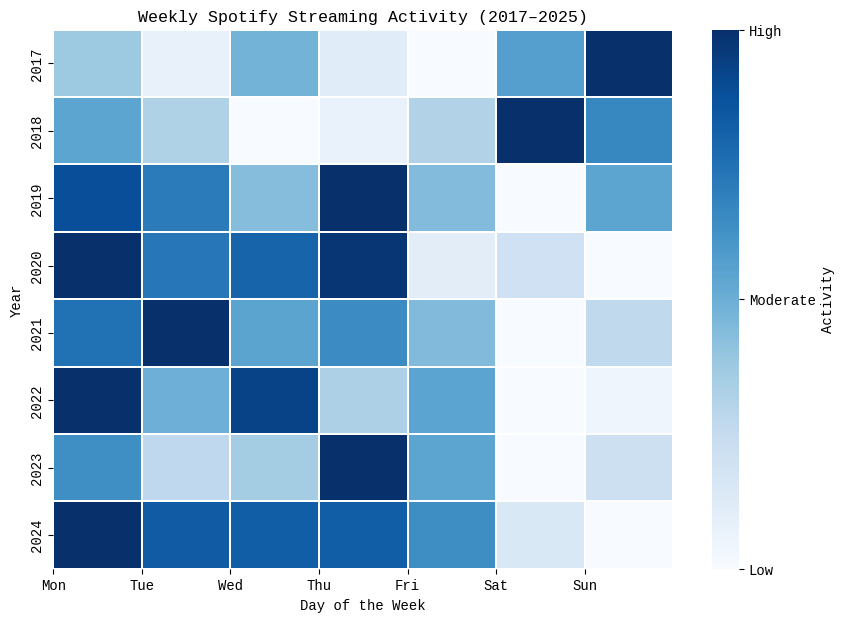

In [ ]:
# Convert the timestamps to datetime and convert to a dataframe
for entry in stream_data:
    entry['ts'] = pd.to_datetime(entry['ts'], utc=True)
df = pd.DataFrame(stream_data)

# Extract year and day of week from the timestamp ts
df['year'] = df['ts'].dt.year
df['dow'] = df['ts'].dt.dayofweek

# Group by year and day of week, and count streams
weekly_activity = df.groupby(['year', 'dow']).size().reset_index(name='stream_count')
hm_data = weekly_activity.pivot(index='year', columns='dow', values='stream_count')
hm_data = hm_data.drop([2016, 2025], axis=0)

# Set up the plot
plt.figure(figsize=(10, 7))

# Normalize the color scale for each year independently
for year in hm_data.index:
    year_data = hm_data.loc[year, :]
    norm = (year_data - year_data.min()) / (year_data.max() - year_data.min())
    hm_data.loc[year, :] = norm

# Create the heatmap
ax = sns.heatmap(hm_data, cmap='Blues', annot=False, linewidths=0.1, cbar_kws={'label': 'Activity'})
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['Low', 'Moderate', 'High'])

# Show the heatmap
plt.rcParams['font.family'] = 'Liberation Mono'
plt.xlabel('Day of the Week')
plt.ylabel('Year')
plt.title('Weekly Spotify Streaming Activity (2017–2025)')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

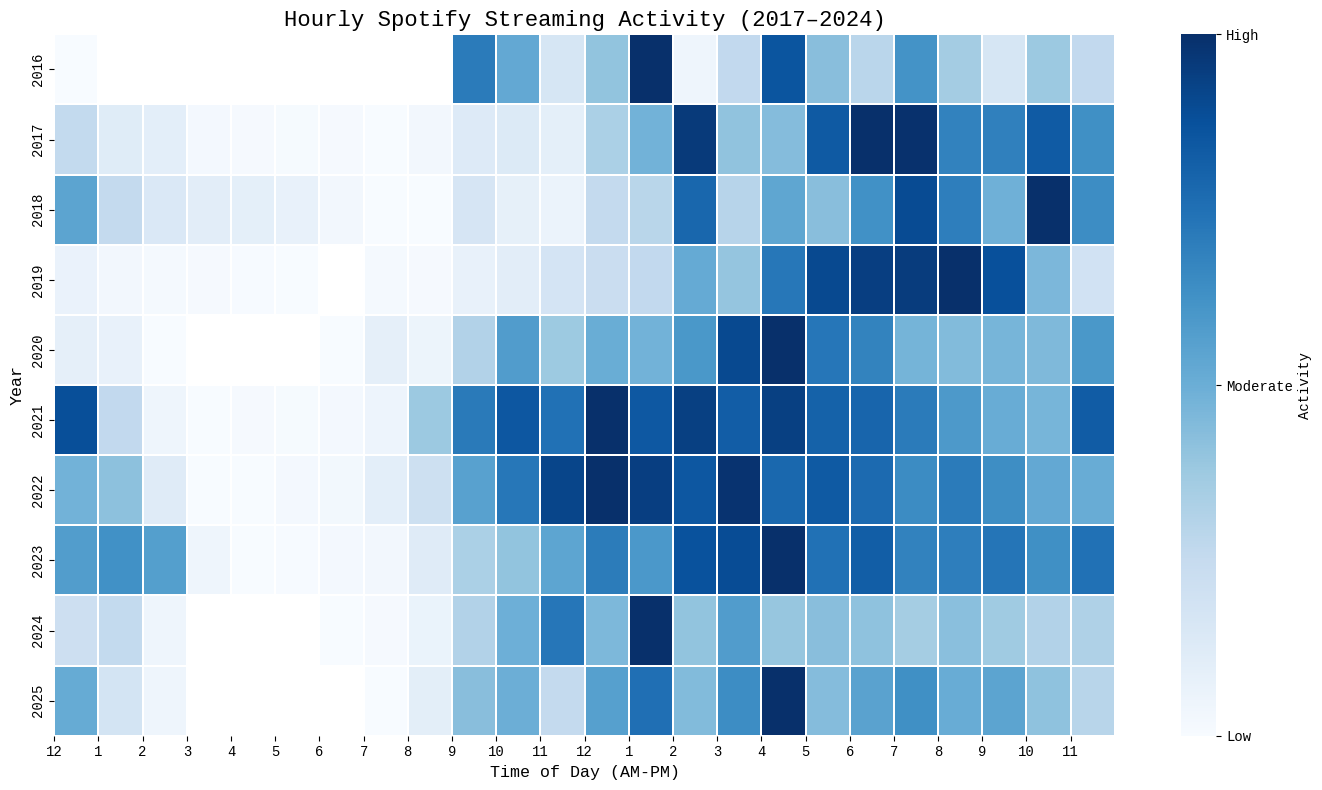

In [ ]:
# Convert the timestamps to datetime and convert to a dataframe
for entry in stream_data:
    entry['ts'] = pd.to_datetime(entry['ts'], utc=True).tz_convert('US/Eastern') # Convert UTC to EST
df = pd.DataFrame(stream_data)

# Extract year and hour from the timestamp ts
df['year'] = df['ts'].dt.year
df['hour'] = df['ts'].dt.hour

# Group by year and hour and count streams
hourly_activity = df.groupby(['year', 'hour']).size().reset_index(name='stream_count')
hm_data = hourly_activity.pivot(index='year', columns='hour', values='stream_count')

# Normalize activity for each year independently
for year in hm_data.index:
    year_data = hm_data.loc[year, :]
    norm = (year_data - year_data.min()) / (year_data.max() - year_data.min())
    hm_data.loc[year, :] = norm

# Set up the plot
plt.figure(figsize=(14, 8))

# Create the heatmap
ax = sns.heatmap(hm_data, cmap='Blues', annot=False, linewidths=0.1, cbar_kws={'label': 'Activity'})
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['Low', 'Moderate', 'High'])

# Show the heatmap
plt.rcParams['font.family'] = 'Liberation Mono'
plt.xlabel('Time of Day (AM-PM)', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.title('Hourly Spotify Streaming Activity (2017–2024)', fontsize=16)
hour_labels = ['12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
plt.xticks(ticks=range(24), labels=hour_labels+hour_labels)
plt.tight_layout()
plt.show()

### Advertising & Inferences

<ipython-input-14-f998c832a669>:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3235756385068762' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hm_data.loc[dow, :] = norm
<ipython-input-14-f998c832a669>:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3862475442043222' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hm_data.loc[dow, :] = norm
<ipython-input-14-f998c832a669>:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12259332023575638' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hm_data.loc[dow, :] = norm
<ipython-input-14-f998c832a669>:18: FutureWarning: Setting an item of incompatible dtype is depr

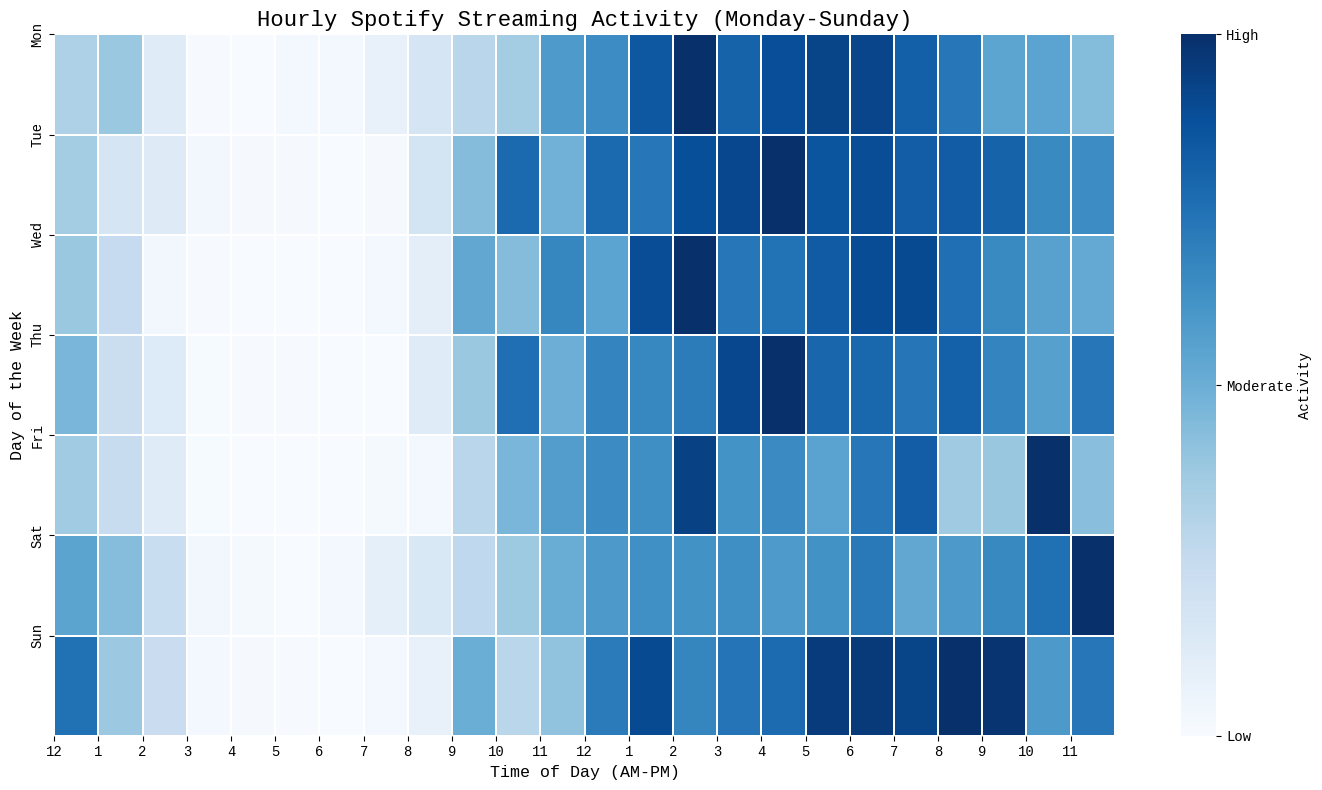

In [ ]:
# Convert the timestamps to datetime and convert to a dataframe
for entry in stream_data:
    entry['ts'] = pd.to_datetime(entry['ts'], utc=True).tz_convert('US/Eastern') # Convert UTC to EST
df = pd.DataFrame(stream_data)

# Extract year and hour from the timestamp ts
df['dow'] = df['ts'].dt.dayofweek
df['hour'] = df['ts'].dt.hour

# Group by year and hour and count streams
hourly_activity = df.groupby(['dow', 'hour']).size().reset_index(name='stream_count')
hm_data = hourly_activity.pivot(index='dow', columns='hour', values='stream_count')

# Normalize activity for each year independently
for dow in hm_data.index:
    dow_data = hm_data.loc[dow, :]
    norm = (dow_data - dow_data.min()) / (dow_data.max() - dow_data.min())
    hm_data.loc[dow, :] = norm

# Set up the plot
plt.figure(figsize=(14, 8))

# Create the heatmap
ax = sns.heatmap(hm_data, cmap='Blues', annot=False, linewidths=0.1, cbar_kws={'label': 'Activity'})
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['Low', 'Moderate', 'High'])

# Show the heatmap
plt.rcParams['font.family'] = 'Liberation Mono'
plt.xlabel('Time of Day (AM-PM)', fontsize=12)
plt.ylabel('Day of the Week', fontsize=12)
plt.title('Hourly Spotify Streaming Activity (Monday-Sunday)', fontsize=16)
hour_labels = ['12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
plt.xticks(ticks=range(24), labels=hour_labels+hour_labels)
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()

In [12]:
# Inferred university (based on location data)
ip2loc = IP2Location.IP2Location('/content/drive/MyDrive/Datasets/Spotify/Geolocation/IP2LOCATION-LITE-DB5.IPV6.BIN')

# Get latitude, longitude, and city from a given IP
def ip_info(addr):
  try:
    entry = ip2loc.get_all(addr)
    lat, lon, city = entry.latitude, entry.longitude, entry.city
    return float(lat), float(lon), city
  except:
    return None, None, None

# Get geolocations for every unique IP
unique_ips = set(entry.get('ip') for entry in stream_data if entry.get('ip') is not None)
location_data = {}
for ip in unique_ips:
    lat, lon, city = ip_info(ip)
    if lat and lon and city:
        location_data[ip] = {
            'city': city,
            'latitude': lat,
            'longitude': lon,
            'total_streams': 0
        }

common_cities = {}
for key,value in location_data.items():
    if value['city'] in common_cities:
        common_cities[value['city']] += 1
    else:
        common_cities[value['city']] = 0

print(f'Most common city: {max(common_cities,key=common_cities.get)}')
print('Inferred university: University of Maryland College Park')

# Worst day to target you
for entry in stream_data:
    entry['ts'] = pd.to_datetime(entry['ts'], utc=True).tz_convert('US/Eastern') # Convert UTC to EST
df = pd.DataFrame(stream_data)
df['dow'] = df['ts'].dt.dayofweek
daily_activity = df.groupby(['dow'])['ms_played'].sum().reset_index(name='stream_time')
print('Worst day to target you: Friday')
print(daily_activity)

Most common city: College Park
Inferred university: University of Maryland College Park
Worst day to target you: Friday
   dow  stream_time
0    0   5072544691
1    1   4645867656
2    2   4813436607
3    3   4475480821
4    4   3880297695
5    5   4130791970
6    6   4176537115


In [ ]:
# Current device
unique_platforms = set(entry.get('platform') for entry in stream_data if entry.get('platform') is not None)
print(unique_platforms)
print('Current device(s): iPhone 12, Windows laptop')

{'Partner windows_tv microsoft;xbox_one;1fc2d01aa9074dde950e8d3dc0eb1729;;', 'iOS 13.2.3 (iPhone10,4)', 'web_player windows 10;chrome 71.0;desktop', 'Windows 10 (10.0.19041; x64)', 'web_player windows 10;chrome 68.0;desktop', 'Windows 10 (10.0.19042; x64)', 'iOS 14.2 (iPhone11,8)', 'Windows 10 (10.0.16299; x64; AppX)', 'Android-tablet OS 6.0.1 API 23 (samsung, SM-G920P)', 'web_player windows 10;chrome 77.0.3865.120;desktop', 'web_player windows 10;chrome 76.0.3809.132;desktop', 'Windows 10 (10.0.18363; x64)', 'iOS 13.6.1 (iPhone9,1)', 'Android-tablet OS 7.0 API 24 (samsung, SM-G950U)', 'iOS 15.4.1 (iPhone11,8)', 'web_player windows 10;chrome 69.0;desktop', 'Android OS 9 API 28 (samsung, SM-G950U)', 'Partner tizen_tv samsung;un55tu7000fxza;568a50c7e7f64fe3b44a3316ef5590fd;;tpapi', 'iOS 14.4.1 (iPhone11,8)', 'iOS 14.0 (iPhone9,1)', 'Android-tablet OS 7.0 API 24 (samsung, SM-G920P)', 'iOS 14.4 (iPhone11,8)', 'web_player windows 10;chrome 79.0.3945.88;desktop', 'iOS 15.5 (iPhone11,8)', 'iO

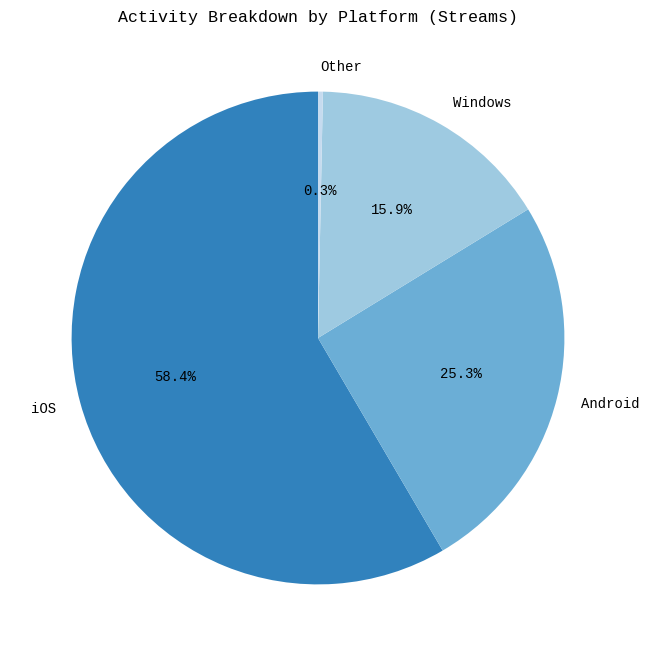

In [6]:
# Best platform to target you (based on time spent)
# Convert the timestamps to datetime and create a dataframe
for entry in stream_data:
    entry['ts'] = pd.to_datetime(entry['ts'], utc=True)
df = pd.DataFrame(stream_data)

# Clean up the platform column by mapping to broad categories
def clean_platform(platform):
    platform = str(platform).lower()
    if 'ios' in platform:
        return 'iOS'
    elif 'android' in platform:
        return 'Android'
    elif 'windows' in platform:
        return 'Windows'
    else:
        return 'Other'
df['platform'] = df['platform'].apply(clean_platform)

# Group by platform and count streams
platform_activity = df['platform'].value_counts()

# Plot the pie chart
plt.rcParams['font.family'] = 'Liberation Mono'
plt.figure(figsize=(8, 8))
plt.pie(platform_activity, labels=platform_activity.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("tab20c", len(platform_activity)))
plt.title('Activity Breakdown by Platform (Streams)')
plt.show()


### Creepiness

In [8]:
# Load the IP2Location database
ip2loc = IP2Location.IP2Location('/content/drive/MyDrive/Datasets/Spotify/Geolocation/IP2LOCATION-LITE-DB5.IPV6.BIN')

# Get latitude, longitude, and city from a given IP
def ip_info(addr):
  try:
    entry = ip2loc.get_all(addr)
    lat, lon, city = entry.latitude, entry.longitude, entry.city
    return float(lat), float(lon), city
  except:
    return None, None, None

# Get geolocations for every unique IP
unique_ips = set(entry.get('ip') for entry in stream_data if entry.get('ip') is not None)
location_data = {}
for ip in unique_ips:
    lat, lon, city = ip_info(ip)
    if lat and lon and city:
        location_data[ip] = {
            'city': city,
            'latitude': lat,
            'longitude': lon,
            'total_streams': 0
        }

# Add up the total streams in every city
city_data = {}
for entry in stream_data:
    ip = entry.get('ip')
    if ip in location_data.keys() and entry.get('ms_played') >= 30000:
        city = location_data[ip]['city']
        if city in city_data.keys():
            city_data[city]['total_streams'] += 1
        else:
            city_data[city] = {'total_streams': 0}

# Set total streams at every IP based on the city it's in
for entry in stream_data:
    ip = entry.get('ip')
    ms = entry.get('ms_played')
    if ip in location_data.keys() and ms >= 30000:
        city = location_data[ip]['city']
        location_data[ip]['total_streams'] = city_data[city]['total_streams']

# Create heatmap (latitude, longitude, and intensity based on total streams)
heatmap_data = [
    [entry['latitude'], entry['longitude'], entry['total_streams']]
    for entry in location_data.values() if entry['total_streams'] > 0
]
hm = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
HeatMap(heatmap_data, radius=15, blur=25, max_zoom=13).add_to(hm)
hm